In [1]:
#pip install librosa seaborn

In [2]:
# Import libraries 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import  ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-01-25 11:25:39.638974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:25:39.841269: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-25 11:25:40.637677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 11:25:40.637817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
Features = pd.read_csv('csv/features_augmentation_pl.csv')
print(Features.shape)

(22788, 163)


In [4]:
# Fill NaN with 0
Features = Features.dropna()
print(Features.shape)

(22786, 163)


In [5]:
Features = Features.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [7]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
np.array(Y).reshape(-1,1)
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['angry', 'happy', 'neutral', 'sad', 'surprise'], dtype=object)]

In [8]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18228, 162), (18228, 5), (4558, 162), (4558, 5))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.1, shuffle=True)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((16405, 162),
 (4558, 162),
 (1823, 162),
 (16405, 162),
 (4558, 162),
 (1823, 162))

In [10]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((16405, 162, 1),
 (16405, 5),
 (4558, 162, 1),
 (4558, 5),
 (1823, 162, 1),
 (1823, 5))

In [11]:
model = Sequential()
model.add(Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))

model.add(Dropout(0.25))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))



model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 128)          768       
                                                                 
 batch_normalization (BatchN  (None, 162, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           164096    
                                                                 
 batch_normalization_1 (Batc  (None, 81, 256)          1024      
 hNormalization)                                                 
                                                        

2023-01-25 11:25:44.015770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:25:44.610936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks= [learning_rate_reduction]

In [13]:
history=model.fit(x_train, y_train, batch_size=64, epochs=64, validation_data=(x_val, y_val),callbacks=callbacks )

Epoch 1/64
257/257 [==============================] - 15s 42ms/step - loss: 1.3590 - accuracy: 0.4449 - val_loss: 2.6919 - val_accuracy: 0.2090 - lr: 0.0010
Epoch 2/64
257/257 [==============================] - 9s 35ms/step - loss: 1.0369 - accuracy: 0.5535 - val_loss: 1.9018 - val_accuracy: 0.3247 - lr: 0.0010
Epoch 3/64
257/257 [==============================] - 9s 35ms/step - loss: 0.9647 - accuracy: 0.5872 - val_loss: 2.2809 - val_accuracy: 0.3686 - lr: 0.0010
Epoch 4/64
257/257 [==============================] - 9s 35ms/step - loss: 0.9148 - accuracy: 0.6078 - val_loss: 2.5046 - val_accuracy: 0.4163 - lr: 0.0010
Epoch 5/64
257/257 [==============================] - 9s 35ms/step - loss: 0.8789 - accuracy: 0.6271 - val_loss: 1.2892 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 6/64
257/257 [==============================] - 9s 35ms/step - loss: 0.8536 - accuracy: 

2023-01-25 11:25:47.529653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-01-25 11:25:47.788921: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [14]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

143/143 [==============================] - 2s 10ms/step - loss: 0.5941 - accuracy: 0.8684
Accuracy of our model on test data :  86.83633208274841 %


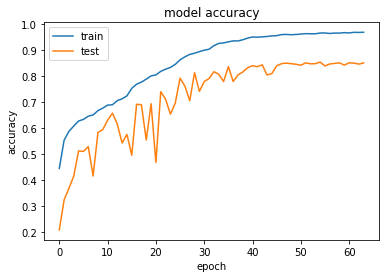

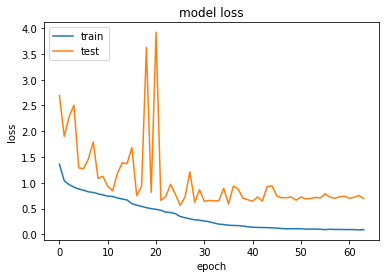

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# predicting on test data.
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

143/143 [==============================] - 1s 6ms/step


In [17]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [18]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,surprise,surprise
2,sad,sad
3,happy,happy
4,neutral,happy
5,angry,angry
6,sad,sad
7,happy,happy
8,surprise,surprise
9,sad,sad


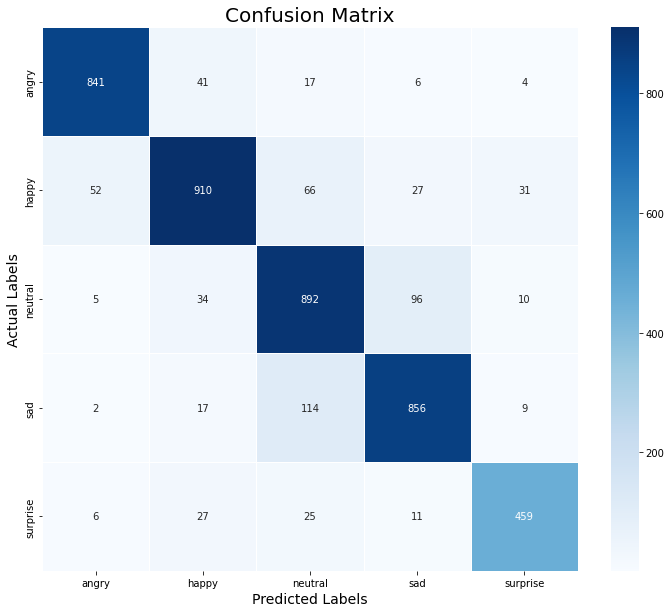

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.93      0.93       909
       happy       0.88      0.84      0.86      1086
     neutral       0.80      0.86      0.83      1037
         sad       0.86      0.86      0.86       998
    surprise       0.89      0.87      0.88       528

    accuracy                           0.87      4558
   macro avg       0.87      0.87      0.87      4558
weighted avg       0.87      0.87      0.87      4558



In [21]:
# Save model and weights
model_name = '5_Emotion_Model_cnn_87.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Model Json/5_Emotion_Model_cnn_87.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /mnt/batch/tasks/shared/LS_root/mounts/clusters/shoaqa161/code/Users/shoaqa16/saved_models/5_Emotion_Model_cnn_82.h5 
